### Imports

In [1]:
import os
import sys
# Set project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import pandas as pd

import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime

#--- Get absolute path to the utils folder---
from pathlib import Path
utils_path = Path.cwd() / "utils"
sys.path.append(str(utils_path))

backtesting_path = Path.cwd() / "backtesting"
sys.path.append(str(backtesting_path))

from notebooks.utils.config_utils import load_config
from notebooks.utils.data_utils import load_dataset, preprocess_data
from notebooks.utils.model_utils import initialise_model, grid_search, get_feature_importance, optimise_threshold
from notebooks.utils.plotting_utils import plot_correlation, plot_scatter, plot_roc_and_prc, plot_classification_report, plot_point_biserial_correlation
from notebooks.utils.pdf_utils import create_markdown_report, update_markdown_with_model_details, convert_markdown_to_html, save_pdf_from_html

from notebooks.backtesting.backtester import Backtester

### Load config.yaml

In [2]:
# Test load
config = load_config()

Config loaded successfully!


### Load the dataset

In [3]:
df = load_dataset(config)
df_selected, selected_features, constructed_features, target_variable = preprocess_data(df, config)

df_selected

📁 Dataset Loaded: 9074 rows, 112 columns
✅ Dataset Preprocessed: 9071 rows, 28 columns


,id_odsp,date,season,league,country,home_team,away_team,score_pre_80,score_ft,game_state_80,...,odds_ratio,shot_to_corner_ratio_pre_80,home_urgency_to_attack,away_urgency_to_attack,home_momentum_to_attack,away_momentum_to_attack,attack_intensity,defensive_pressure,trailing_team_probability,target
0,UFot0hit/,2011-08-05,2012,D1,germany,Borussia Dortmund,Hamburg SV,3-1,3-1,h,...,0.210,1.692,0.000,0.067,0.000,0.067,0,-2,13.477,1
1,Aw5DflLH/,2011-08-06,2012,D1,germany,FC Augsburg,SC Freiburg,1-2,2-2,a,...,0.694,2.429,0.424,0.000,-0.424,-0.000,0,-3,42.373,1
2,CzPV312a/,2011-08-06,2012,F1,france,Paris Saint-Germain,Lorient,0-1,0-1,a,...,0.165,2.222,0.645,0.000,1.935,-0.000,3,0,64.516,1
3,GUOdmtII/,2011-08-06,2012,F1,france,Caen,Valenciennes,1-0,1-0,h,...,0.725,1.900,0.000,0.290,0.000,0.000,0,-2,28.986,1
4,M7PhlM2C/,2011-08-06,2012,F1,france,Brest,Evian Thonon Gaillard,2-2,2-2,d,...,0.595,2.000,0.627,0.373,2.508,0.000,0,-1,25.974,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9069,vJy048Er/,2017-01-22,2017,I1,italy,Empoli,Udinese,0-0,1-0,d,...,0.980,1.250,0.505,0.495,-0.505,0.000,0,0,33.784,1
9070,xAkY8l6R/,2017-01-22,2017,I1,italy,Genoa,Crotone,2-2,2-2,d,...,0.246,2.100,0.802,0.198,-0.802,-0.396,0,0,12.500,1
9071,xSU9scI9/,2017-01-22,2017,E0,england,Chelsea,Hull,1-0,2-0,h,...,0.060,1.000,0.000,0.050,0.000,0.050,1,-2,5.000,1
9072,xY7uZwOI/,2017-01-22,2017,F1,france,AS Monaco,Lorient,4-0,4-0,h,...,0.115,2.375,0.000,0.000,0.000,0.000,0,0,8.696,0


### Plot correlation heatmap (for selected features)

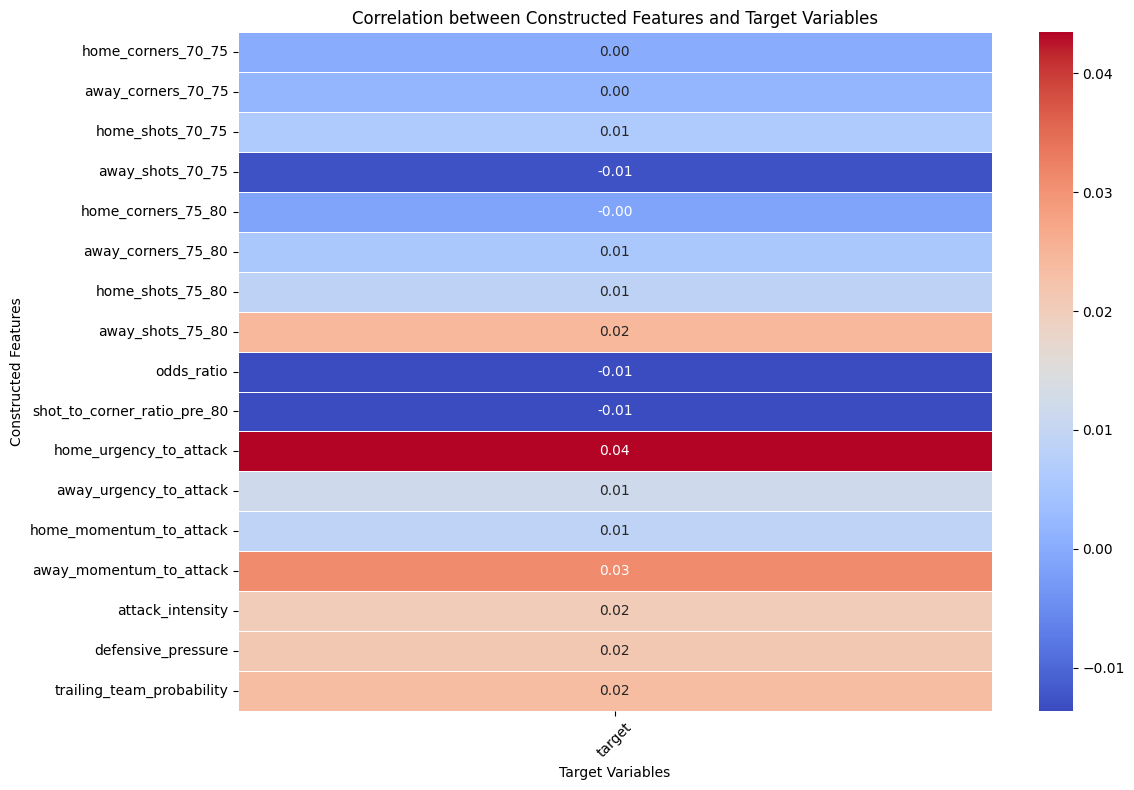

In [4]:
feature_correlation_image_path = plot_correlation(df_selected, selected_features, constructed_features, target_variable)

### Compute Point-Biserial Correlation and P-values

- **Point-biserial correlation**: Measures the strength and correlation between a binary variable (target) and continuous variables (each feature) (higher value better)
- **P-value**: Indicates if the correlation is statistically significant (lower value better)
- **Combined Score**: A reflective measure of both Point-biserial and P-val.

--- TOP 10 FEATURES ---
Feature
home_urgency_to_attack         0.043426
away_momentum_to_attack        0.031043
away_shots_75_80               0.024003
trailing_team_probability      0.022895
defensive_pressure             0.020446
attack_intensity               0.019353
odds_ratio                     0.010949
shot_to_corner_ratio_pre_80    0.010797
away_shots_70_75               0.010085
away_urgency_to_attack         0.008928
Name: Combined Score, dtype: float64
-----------------------


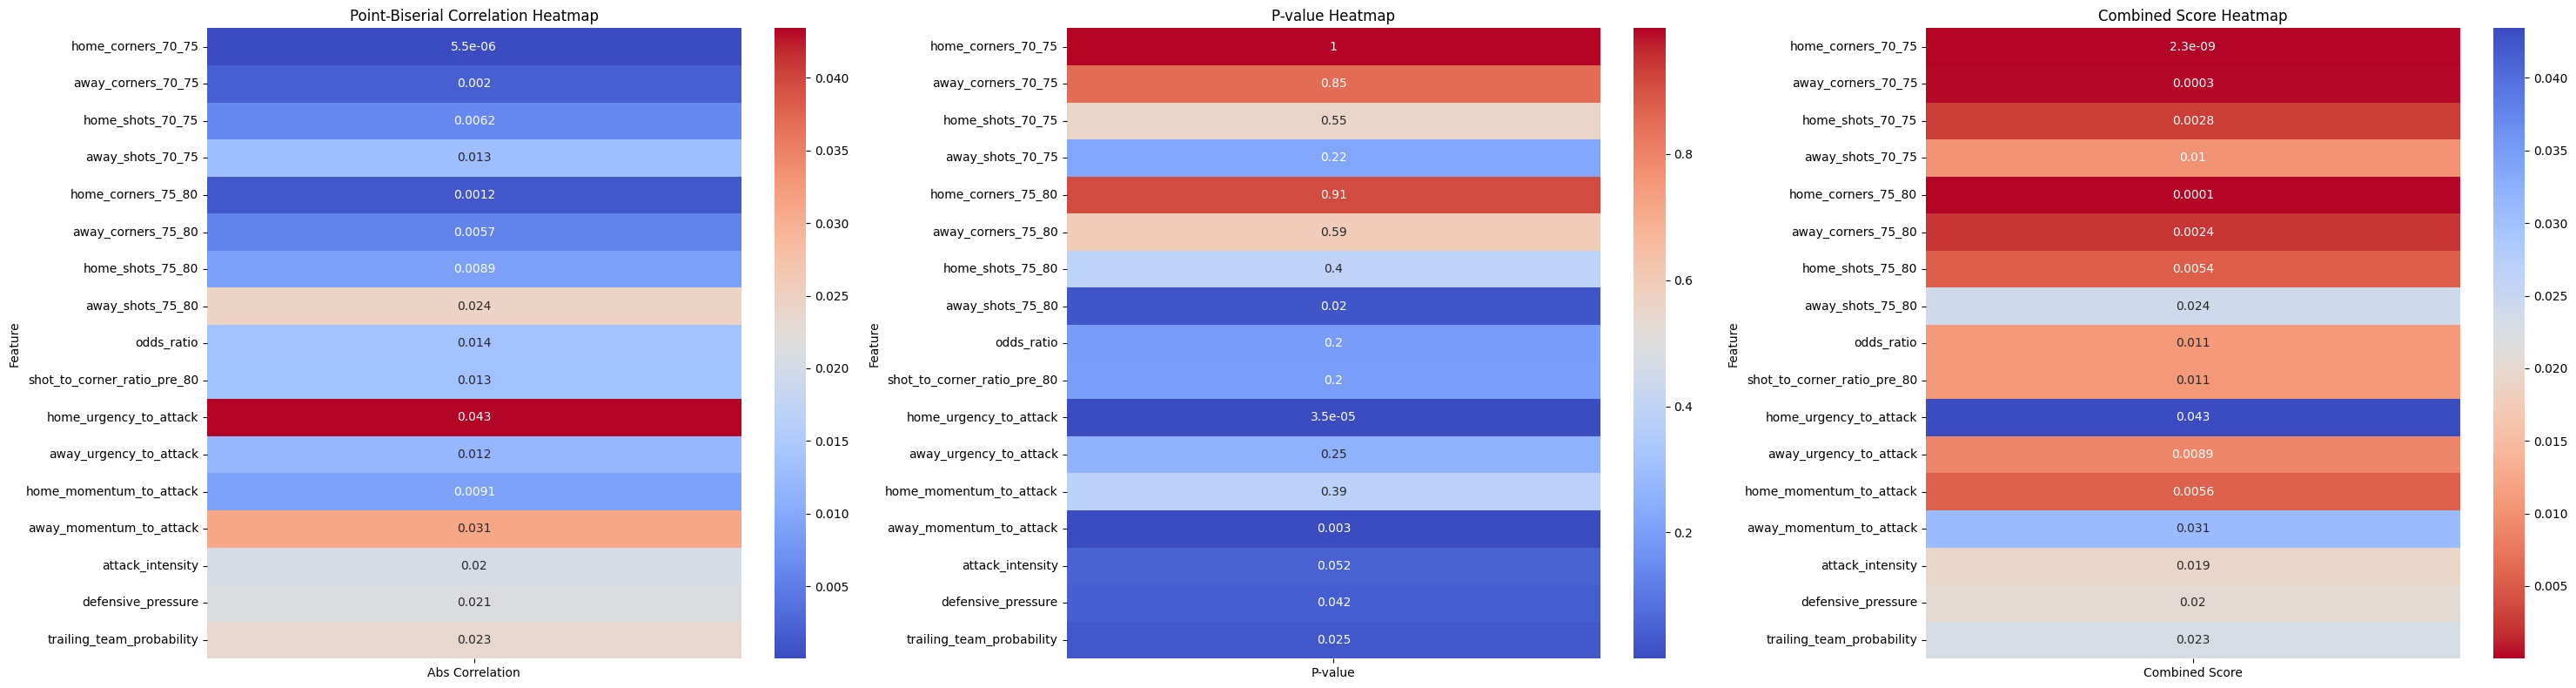

In [5]:
point_biserial_correlation_image_path = plot_point_biserial_correlation(df_selected, selected_features, constructed_features)

# Classification Pipeline

- **Feature Selection**: 
    - Trains only on selected and constructed features
- **Data Splitting**:
    - Exclude the last 500 rows for testing
    - Split remaining data into 80% train and 20% validation sets
- **Model Training Loop**:
    1) Initialise each model from config yaml
    2) Apply MinMax scaling... *only for models that require scaling*
    3) Perform grid search for hyperparameter tuning (if specified) and Train Model
    4) Predict on validation set and display feature importance
    5) Optimise precision-recall threshold
    6) Evaluate model on validation set using optimised threshold
    7) Plot ROC and Precision-Recall graphs
    8) Predict on the test set (last 500 rows) and evaluate
    9) Save the trained model
    10) Save predictions (for backtesting).
    11) Plot Scatter Graph.

In [6]:
def run_classification_pipeline(config, df, selected_features, constructed_features, target_variable, show_output=False, generate_pdf=False): 
    models_to_train = config['model']['classification']['models']
    
    # Step 1: Create the Markdown for the report
    if generate_pdf:
        markdown_content = create_markdown_report(config, feature_correlation_image_path, point_biserial_correlation_image_path, target_variable, selected_features, constructed_features, models_to_train)   
    #Only train on selected and constructed features
    X = df[selected_features + constructed_features]
    y = df[target_variable]

    #Get num of 1s and 0s
    value_counts=y.value_counts()
    num_ones=value_counts.get(1, 0)
    num_zeros=value_counts.get(0, 0)
    total=value_counts.sum()
    implied_1_plus_betting_odds = round(1/(num_ones/total), 4)

    print("--- DATASET STATS ---")
    print(f"Number of 1's: {num_ones}")
    print(f"Number of 0's: {num_zeros}")
    print(f"Total: {total}")
    print(f"Implied 1+ betting odds = {implied_1_plus_betting_odds}")
    print("---------------------")

    #Split data to exclude the last 500 rows for testing
    train_data = df.iloc[:-500]
    test_data = df.iloc[-500:]

    # Split data -> train & validation
    X_train, X_val, y_train, y_val = train_test_split(
        train_data[selected_features + constructed_features],
        train_data[target_variable],
        test_size=0.2,
        random_state=42,
        stratify=train_data[target_variable]
    )

    # Create X and y for testset
    X_test= test_data[selected_features+constructed_features]
    y_test =test_data[target_variable]

    # MinMax Scaling for models that require scaling...
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled =scaler.transform(X_val)
    X_test_scaled =scaler.transform(X_test)

    # --- MODEL TRAINING LOOP ---
    # Train and evaluate each model from the config
    models_to_train = config['model']['classification']['models']
    for model_name in models_to_train:
        print(f"\n-> Training {model_name}...")
    
        # Get the hyperparameters for the model
        hyperparameters = config["model"]["classification"]["hyperparameters"].get(model_name, {})
        do_grid_search=config["model"]["classification"].get("grid_search", False)

        # --- STEP 1: Initialise the model
        model = initialise_model(model_name, hyperparameters)

        # --- STEP 2: Select Scaled or Unscaled Data ---
        if model_name in ["logistic_regression", "svc", "xgboost"]:
            X_train, X_val, X_test = X_train_scaled, X_val_scaled, X_test_scaled
        
        # --- STEP 3: Grid Search (optional) ---
        if do_grid_search:
            optimal_model = grid_search(model_name, model, X_train, y_train, show_output)
        else:
            model.fit(X_train, y_train)
            optimal_model = model

        # --- STEP 4: Predict on the validation set ---
        y_pred_val = optimal_model.predict_proba(X_val)[:, 1]

        #Display Feature Importance
        feature_importances = get_feature_importance(optimal_model, model_name, selected_features, constructed_features)
        if show_output:
            print("\n### Top 8 and Bottom 5 Feature Importance ###")
            print(feature_importances)

        # --- STEP 5: Precision-Recall Threshold Optimisation ---
        best_threshold, optimal_threshold = optimise_threshold(y_pred_val, y_val, show_output)

        # optimal_threshold=0
        # --- STEP 6: Model Evaluation ---
        y_pred_threshold =(y_pred_val >= optimal_threshold).astype(int)
        if show_output:
            print(f"\n### Classification Report (threshold={optimal_threshold}):\n") 
            print(classification_report(y_val, y_pred_threshold))
        classification_report_str_1 = classification_report(y_val, y_pred_threshold, output_dict=False)

        # --- STEP 7: Plot ROC and Precision-Recall curves ---
        fpr,tpr,_ =roc_curve(y_val, y_pred_val)
        roc_auc =roc_auc_score(y_val, y_pred_val)
        precision,recall,_ =precision_recall_curve(y_val, y_pred_val)
        pr_auc=auc(recall, precision)

        # --- STEP 8: Test on test set (last 500 rows) ---
        # Predict on the final test data (last 500 rows)
        y_probs_final =optimal_model.predict_proba(X_test)[:, 1]
        y_pred_final=(y_probs_final >=optimal_threshold).astype(int)

        #Evaluate on the last 500 rows (final simulation)
        if show_output:
            print("\n### Prediction on last 500 rows: ###")
            print(classification_report(y_test, y_pred_final))
        classification_report_str_2 = classification_report(y_test, y_pred_final, output_dict=False)

        classification_report_image_path = plot_classification_report(optimal_model, X_val,y_val,X_test,y_test, model_name, show_output)
        roc_prc_image_path = plot_roc_and_prc(fpr, tpr, roc_auc,precision,recall, pr_auc,model_name,show_output)

        # --- STEP 9: Save Model ---
        model_dir = "../models" 
        if not os.path.exists(model_dir): # Ensure the directory exists
            os.makedirs(model_dir)
        # Save the model
        joblib.dump(optimal_model, os.path.join(model_dir, f"{model_name.replace(' ', '_').lower()}_model.pkl"))
        if show_output:
            print(f"{model_name} model saved.")

        prediction_file = f"../data/predictions/{model_name.replace(' ', '_').lower()}_predictions.csv"
        # --- STEP 10: Save Predictions ---
        results_df = pd.DataFrame({
            'kaggle_id': test_data['id_odsp'],
            'model_predicted_binary': y_pred_final,
            'actual_result': y_test
        })
        results_df.to_csv(prediction_file, index=False)
        if show_output:
            print(f"Predictions saved for {model_name}.")

        # --- STEP 11: Plot Scatter Graph ---
        scatter_image_path = plot_scatter(y_probs_final, y_test, model_name, show_output, optimal_threshold=optimal_threshold)

        if show_output:
            print(f"\n-> Running Backtest for {model_name}...")
        odds_file = config["paths"]["total_corner_odds"]  # Ensure this exists in config.yaml
        backtester = Backtester(config, odds_file=odds_file, model_file=prediction_file, model_type="classification", target_mean=implied_1_plus_betting_odds)
        backtesting_image_path, backtesting_results_list = backtester.run(show_output)

        if generate_pdf:
            #Finally, update markdown with generated outputs...
            markdown_content = update_markdown_with_model_details(
                markdown_content,
                model_name,
                feature_importances,
                best_threshold,
                classification_report_str_1,
                classification_report_str_2,
                classification_report_image_path,
                roc_prc_image_path,
                scatter_image_path,
                backtesting_results_list,
                backtesting_image_path
            )

    if generate_pdf:
        now = datetime.now()
        date_time_str = now.strftime("%Y-%m-%d, %H:%M")
        # Convert Markdown to html and save as pdf to reports/model_reports/
        html_content = convert_markdown_to_html(markdown_content)
        save_pdf_from_html(html_content, f'../reports/model_reports/{date_time_str}_model_report.pdf')
        print("📄 Saved PDF Report")
    
    print("✅ Finished Running Pipeline")

--- DATASET STATS ---
Number of 1's: 6895
Number of 0's: 2176
Total: 9071
Implied 1+ betting odds = 1.3156
---------------------

-> Training random_forest...

### Top 8 and Bottom 5 Feature Importance ###
                        Feature  Importance
9   shot_to_corner_ratio_pre_80    0.145922
8                    odds_ratio    0.141861
16    trailing_team_probability    0.130788
11       away_urgency_to_attack    0.088757
10       home_urgency_to_attack    0.071939
13      away_momentum_to_attack    0.068488
15           defensive_pressure    0.064494
12      home_momentum_to_attack    0.060289
14             attack_intensity    0.025389
0            home_corners_70_75    0.020642
4            home_corners_75_80    0.018966
5            away_corners_75_80    0.017935
1            away_corners_70_75    0.017149

### Precision-Recall Tradeoff at Different Thresholds ###

Threshold   Precision   Recall      
------------------------------------
0.50        0.7624      0.9800      
0.52   

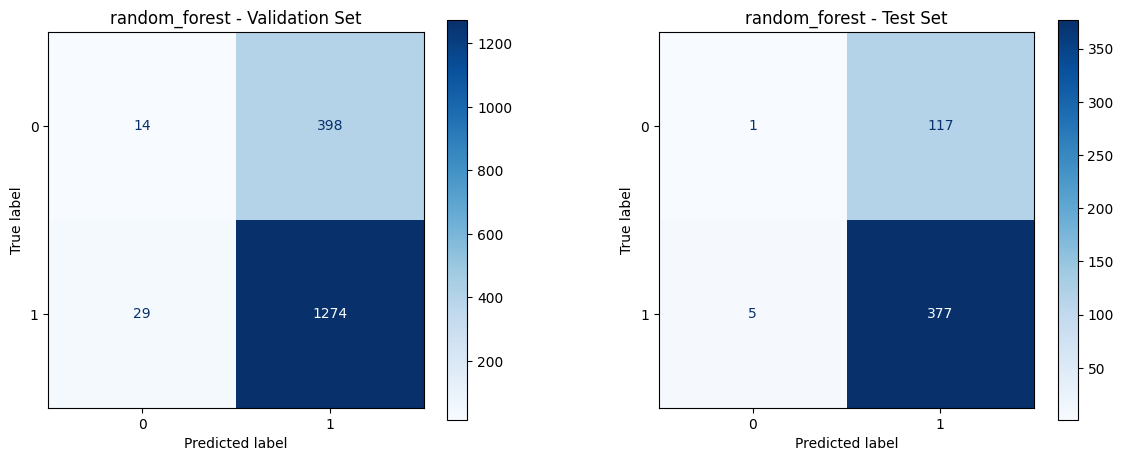

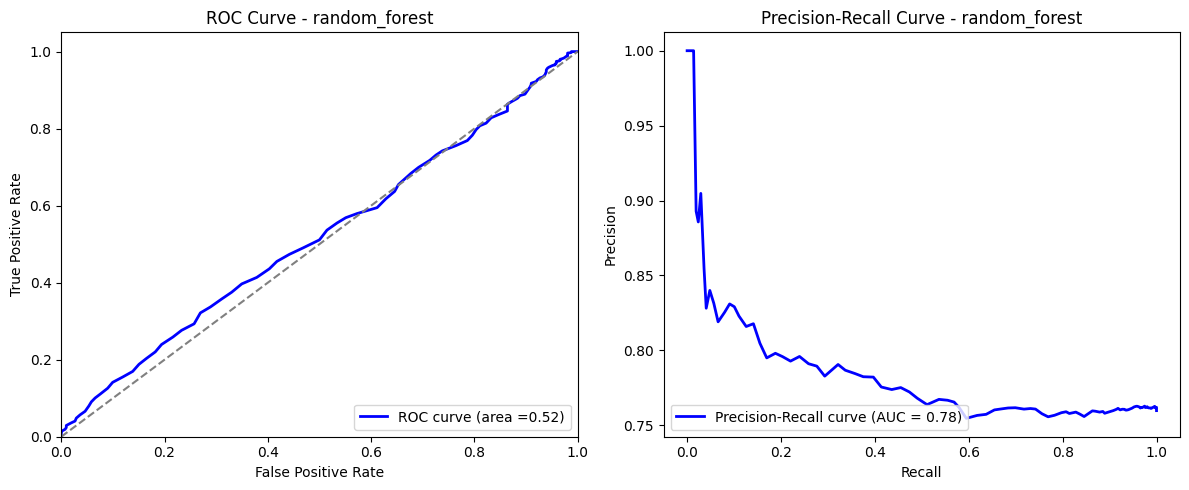

random_forest model saved.
Predictions saved for random_forest.


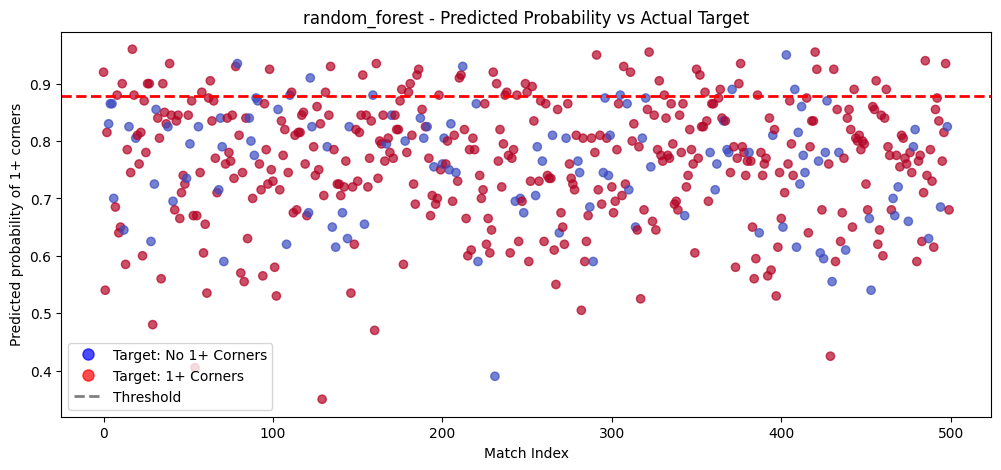


-> Running Backtest for random_forest...

📊 Betting Trade Summary:
Match ID   Odds       Stake      Profit     Outcome    Bank      
UilpC17U/  1.27       100.00     27.01      1          1027.01   
fis8of83/  1.29       102.70     29.47      1          1056.47   
zBEayApd/  1.28       105.65     29.96      1          1086.43   
zF2xGqaj/  1.35       108.64     38.32      1          1124.75   
dKLrKm2e/  1.26       112.47     29.61      1          1154.36   
2DKlSrzn/  1.36       115.44     41.50      1          1195.86   
On1MHIla/  1.28       119.59     33.71      1          1229.57   
SvbwEzlO/  1.28       122.96     34.24      1          1263.81   
fRyiXcln/  1.26       126.38     33.06      1          1296.88   
APSZzh01/  1.29       129.69     -129.69    0          1167.19   
8tbIt2FP/  1.28       116.72     32.70      1          1199.89   
t4ghyizq/  1.29       119.99     34.83      1          1234.72   
GnBWIbNI/  1.28       123.47     -123.47    0          1111.25   
GtQaVyJb

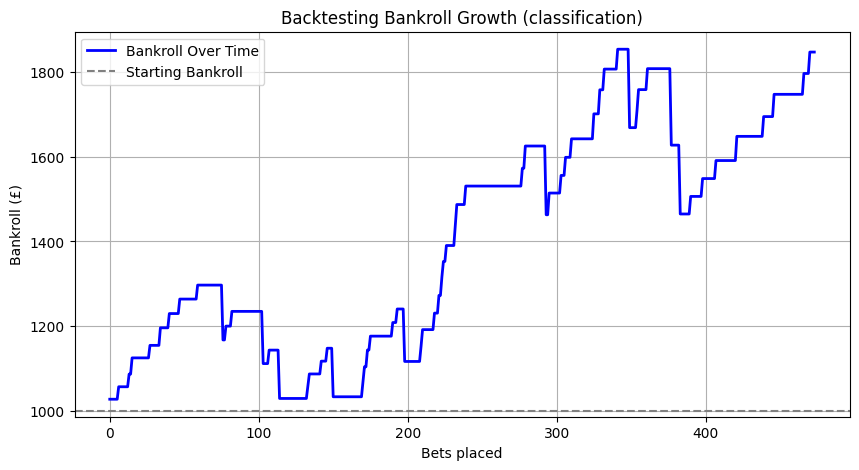


-> Training logistic_regression...

### Top 8 and Bottom 5 Feature Importance ###
                        Feature  Importance
13      away_momentum_to_attack    0.910716
12      home_momentum_to_attack    0.846280
15           defensive_pressure    0.513548
14             attack_intensity    0.427593
10       home_urgency_to_attack    0.414180
7              away_shots_75_80    0.224456
16    trailing_team_probability    0.184375
2              home_shots_70_75    0.103626
5            away_corners_75_80   -0.048191
3              away_shots_70_75   -0.160299
4            home_corners_75_80   -0.218407
8                    odds_ratio   -0.239331
9   shot_to_corner_ratio_pre_80   -0.340174

### Precision-Recall Tradeoff at Different Thresholds ###

Threshold   Precision   Recall      
------------------------------------
0.50        0.7859      0.4873      
0.52        0.7898      0.3200      
0.55        0.7846      0.1566      

### Recommended Threshold for Maximum Precision ###
Opt

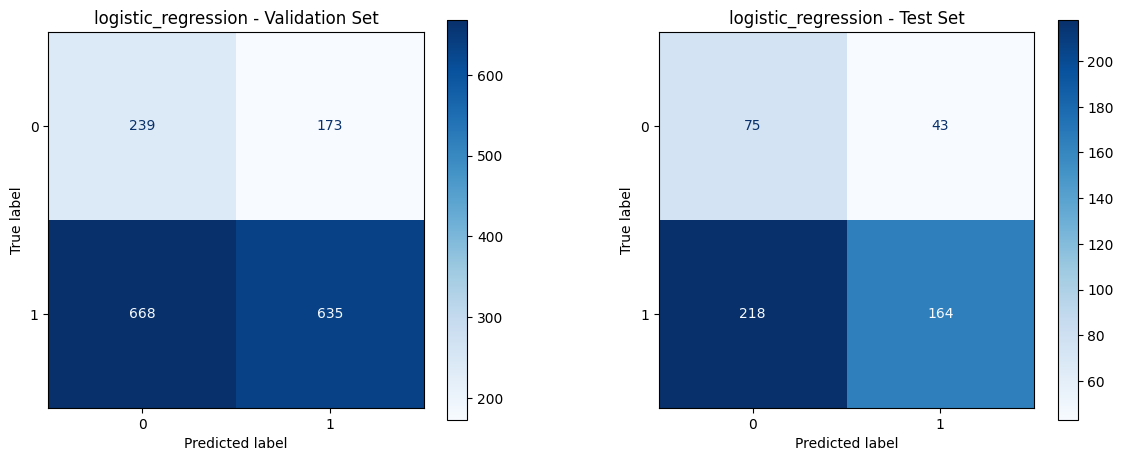

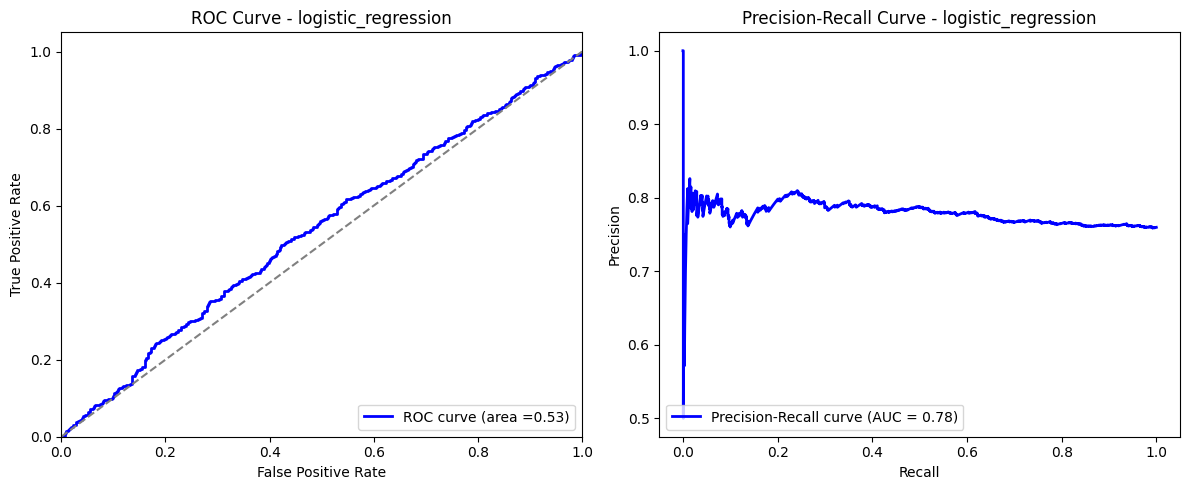

logistic_regression model saved.
Predictions saved for logistic_regression.


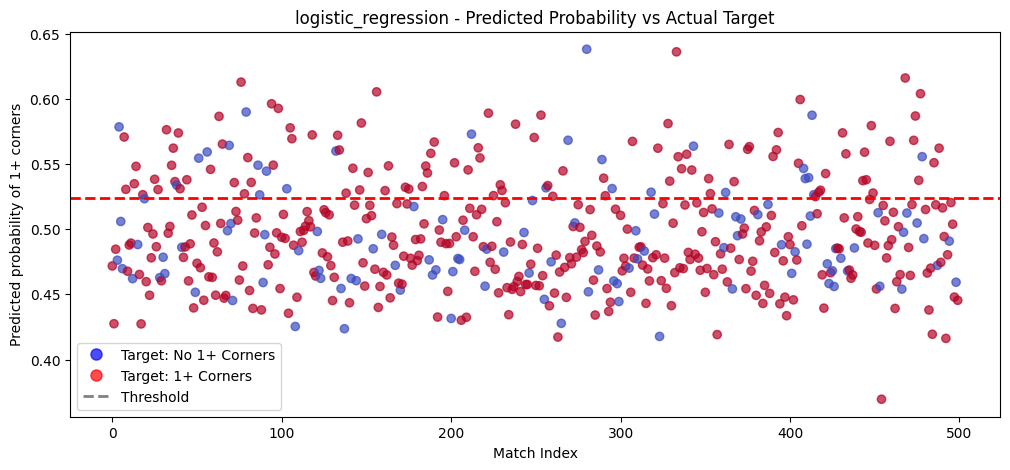


-> Running Backtest for logistic_regression...

📊 Betting Trade Summary:
Match ID   Odds       Stake      Profit     Outcome    Bank      
UilpC17U/  1.27       100.00     27.01      1          1027.01   
lE2s0gNd/  1.28       102.70     28.95      1          1055.95   
8IJfW4hn/  1.28       105.60     -105.60    0          950.35    
URKjXpwt/  1.28       95.04      26.15      1          976.50    
j1ktDshO/  1.28       97.65      27.19      1          1003.70   
zF2xGqaj/  1.35       100.37     35.40      1          1039.10   
vamSAs5B/  1.32       103.91     32.79      1          1071.89   
buEcQM4b/  1.27       107.19     -107.19    0          964.70    
Cluu8ukU/  1.28       96.47      27.19      1          991.89    
jZjW91KH/  1.28       99.19      27.29      1          1019.18   
dKLrKm2e/  1.26       101.92     26.84      1          1046.02   
QcIJL0w0/  1.28       104.60     29.31      1          1075.33   
fZsxqrxh/  1.28       107.53     29.77      1          1105.09   
On

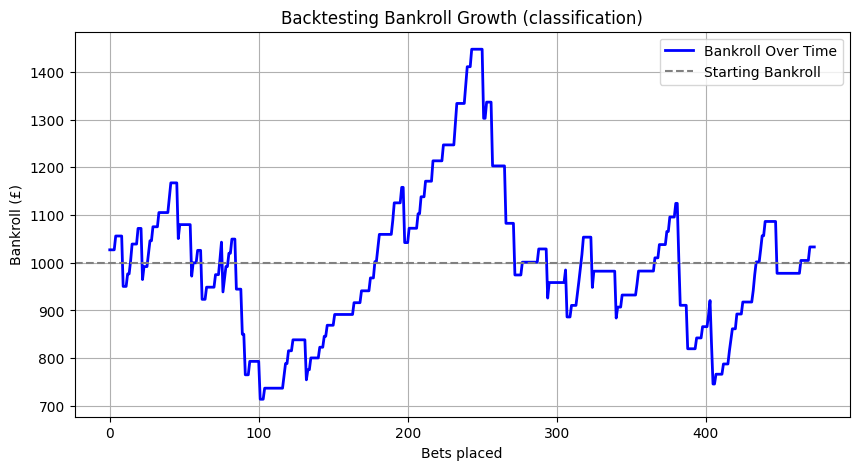


-> Training svc...

### Top 8 and Bottom 5 Feature Importance ###
                        Feature  Importance
0            home_corners_70_75         0.0
9   shot_to_corner_ratio_pre_80         0.0
15           defensive_pressure         0.0
14             attack_intensity         0.0
13      away_momentum_to_attack         0.0
12      home_momentum_to_attack         0.0
11       away_urgency_to_attack         0.0
10       home_urgency_to_attack         0.0
5            away_corners_75_80         0.0
4            home_corners_75_80         0.0
3              away_shots_70_75         0.0
2              home_shots_70_75         0.0
16    trailing_team_probability         0.0

### Precision-Recall Tradeoff at Different Thresholds ###

Threshold   Precision   Recall      
------------------------------------
0.50        0.7598      1.0000      
0.52        0.7598      1.0000      
0.55        0.7598      1.0000      
0.57        0.7598      1.0000      
0.59        0.7598      1.0000     

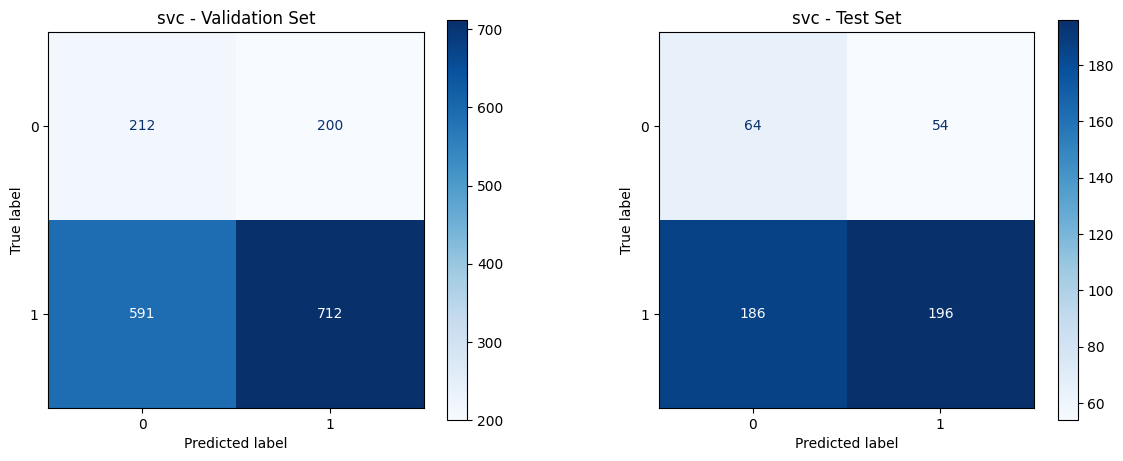

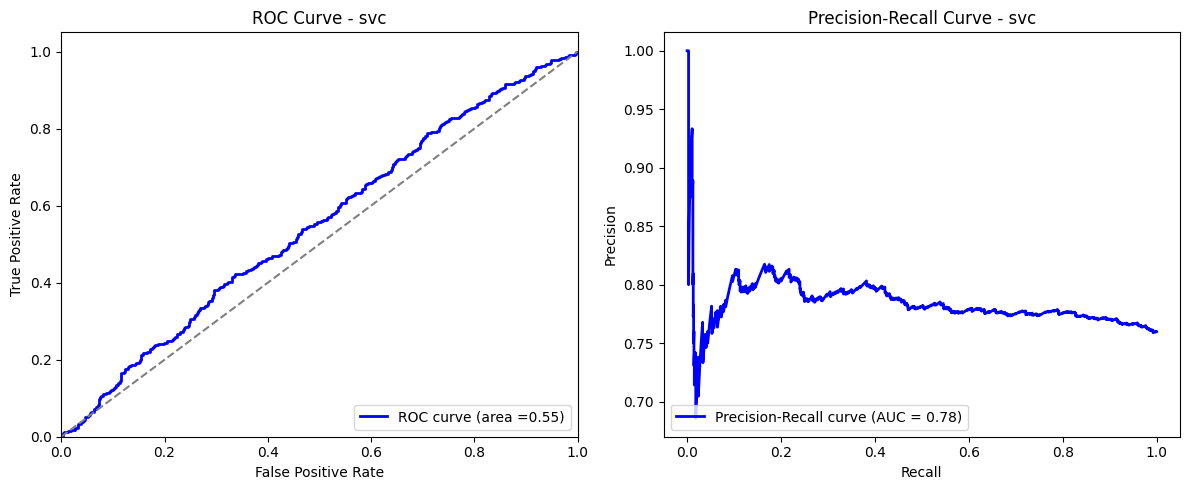

svc model saved.
Predictions saved for svc.


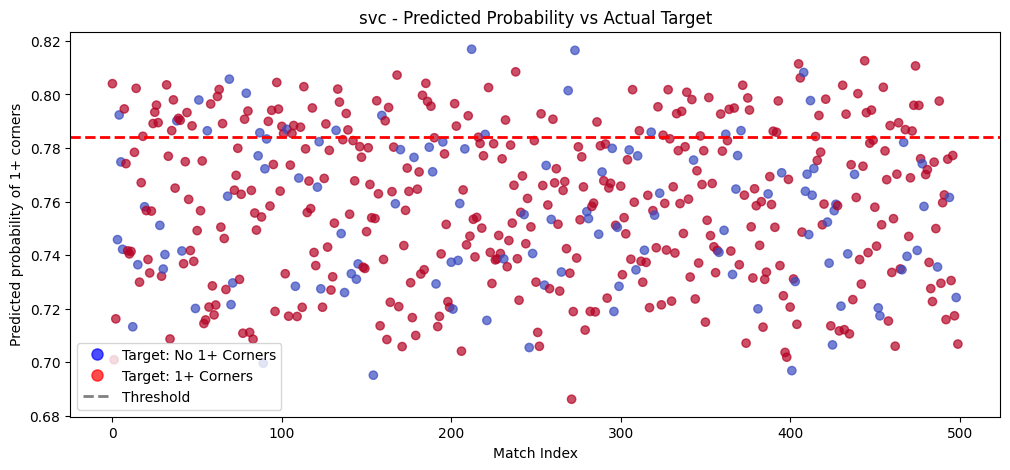


-> Running Backtest for svc...

📊 Betting Trade Summary:
Match ID   Odds       Stake      Profit     Outcome    Bank      
lE2s0gNd/  1.28       100.00     28.19      1          1028.19   
8IJfW4hn/  1.28       102.82     -102.82    0          925.37    
URKjXpwt/  1.28       92.54      25.46      1          950.83    
zF2xGqaj/  1.35       95.08      33.54      1          984.36    
vamSAs5B/  1.32       98.44      31.07      1          1015.43   
tnOWZ4jM/  1.35       101.54     35.13      1          1050.56   
buEcQM4b/  1.27       105.06     -105.06    0          945.50    
Cluu8ukU/  1.28       94.55      26.65      1          972.15    
jZjW91KH/  1.28       97.21      26.74      1          998.89    
dKLrKm2e/  1.26       99.89      26.30      1          1025.20   
fZsxqrxh/  1.28       102.52     28.38      1          1053.57   
2DKlSrzn/  1.36       105.36     37.87      1          1091.45   
vN37T2Tk/  1.36       109.14     38.86      1          1130.31   
On1MHIla/  1.28   

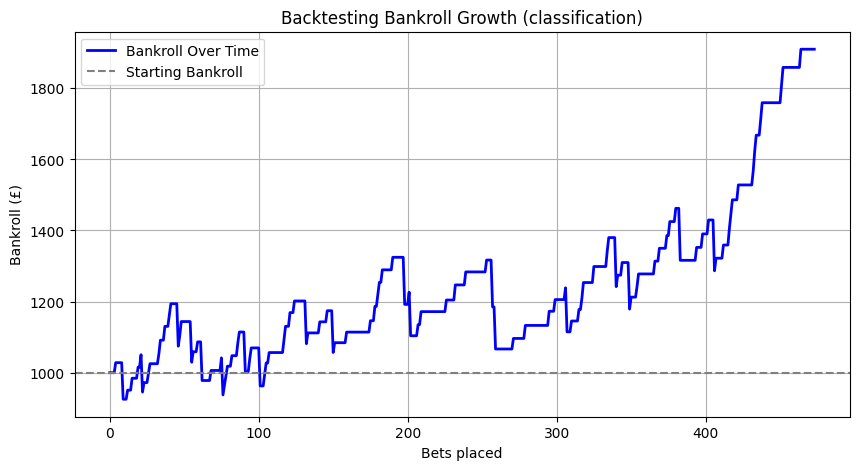


-> Training xgboost...

### Top 8 and Bottom 5 Feature Importance ###
                        Feature  Importance
0            home_corners_70_75    0.084431
5            away_corners_75_80    0.078438
11       away_urgency_to_attack    0.074995
14             attack_intensity    0.065875
10       home_urgency_to_attack    0.064696
7              away_shots_75_80    0.061824
9   shot_to_corner_ratio_pre_80    0.060123
13      away_momentum_to_attack    0.058942
15           defensive_pressure    0.051838
3              away_shots_70_75    0.047017
6              home_shots_75_80    0.046370
4            home_corners_75_80    0.042407
1            away_corners_70_75    0.040922

### Precision-Recall Tradeoff at Different Thresholds ###

Threshold   Precision   Recall      
------------------------------------
0.50        0.7598      1.0000      
0.52        0.7607      1.0000      
0.55        0.7614      0.9992      
0.57        0.7611      0.9977      
0.59        0.7629      0.9954 

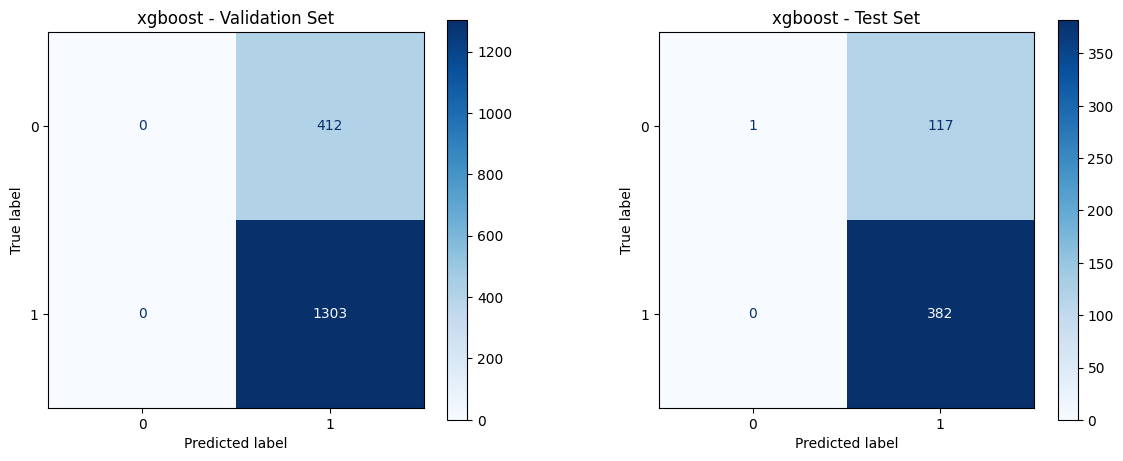

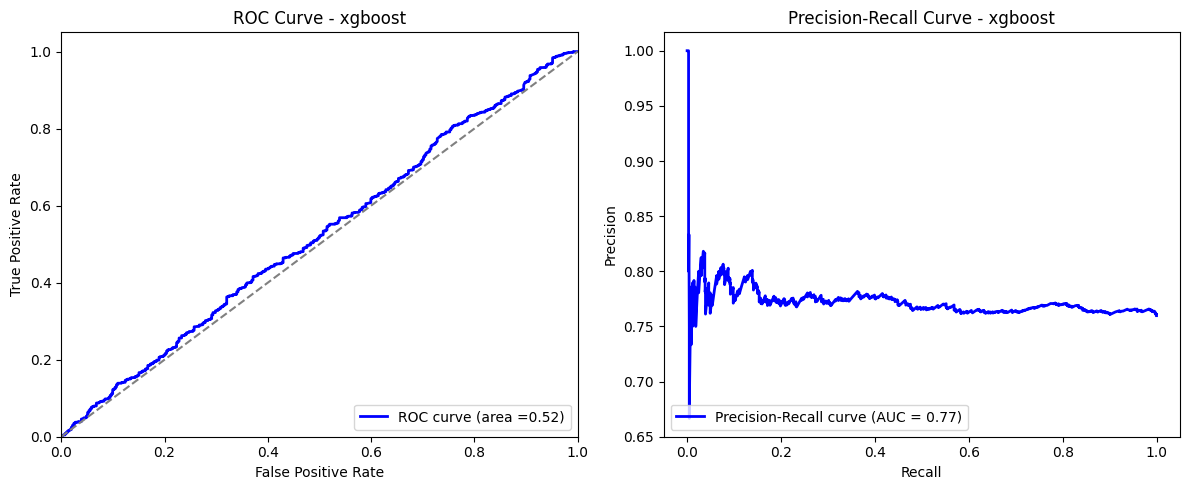

xgboost model saved.
Predictions saved for xgboost.


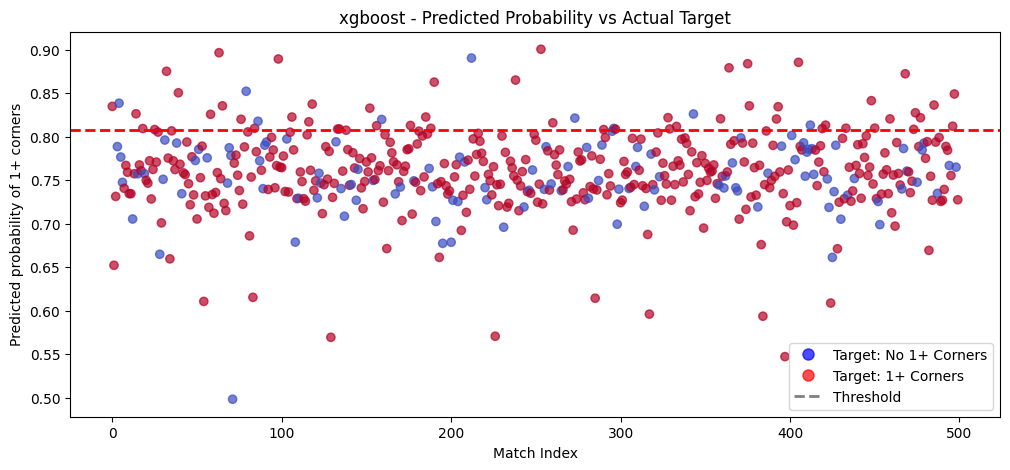


-> Running Backtest for xgboost...

📊 Betting Trade Summary:
Match ID   Odds       Stake      Profit     Outcome    Bank      
lE2s0gNd/  1.28       100.00     28.19      1          1028.19   
8IJfW4hn/  1.28       102.82     -102.82    0          925.37    
zF2xGqaj/  1.35       92.54      32.64      1          958.01    
vamSAs5B/  1.32       95.80      30.23      1          988.24    
Cluu8ukU/  1.28       98.82      27.85      1          1016.09   
dKLrKm2e/  1.26       101.61     26.76      1          1042.85   
SvbwEzlO/  1.28       104.28     29.04      1          1071.89   
juQ6O2gs/  1.29       107.19     30.76      1          1102.65   
fRyiXcln/  1.26       110.26     28.85      1          1131.49   
APSZzh01/  1.29       113.15     -113.15    0          1018.34   
4lwgz0hg/  1.28       101.83     28.53      1          1046.87   
t4ghyizq/  1.29       104.69     30.39      1          1077.27   
KbpgCMFC/  1.34       107.73     36.91      1          1114.17   
Qcvkytwm/  1.2

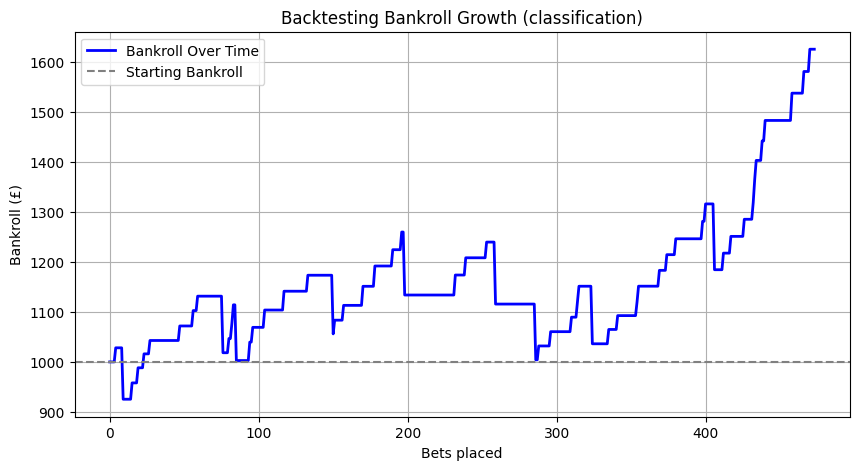

📄 Saved PDF Report
✅ Finished Running Pipeline


In [7]:
run_classification_pipeline(config, df_selected, selected_features, constructed_features, target_variable=target_variable[0], show_output=True, generate_pdf=True)